In [1]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS

def complex_mvn_logpdf(z, Gamma):
    """Log-pdf for z ~ CN(0, Gamma), z: (L, K), Gamma: (K, K) Hermitian"""
    L, K = z.shape
    Gamma_inv = jnp.linalg.inv(Gamma)
    sign, logdet = jnp.linalg.slogdet(Gamma)

    # z: (L, K), Gamma_inv: (K, K)
    # Compute quadratic form for each row: zᵢᴴ Γ⁻¹ zᵢ
    quad = jnp.real(jnp.einsum("bi,ij,bj->b", jnp.conj(z), Gamma_inv, z))  # shape (L,)

    return -K * jnp.log(jnp.pi) - logdet - quad

In [2]:
import numpy as np

def simulate_cscn_data(K=3, n_samples=500, seed=0):
    rng = np.random.default_rng(seed)

    # Random low-rank complex A
    r = K
    A = rng.normal(0, 1, size=(K, r)) + 1j * rng.normal(0, 1, size=(K, r))

    # Hermitian PSD
    Gamma = A @ A.conj().T + 0.5 * np.eye(K)

    from scipy.linalg import cholesky
    L = cholesky(Gamma, lower=True)

    # Standard complex normals
    z_std_normal = rng.normal(size=(n_samples, K)) + 1j * rng.normal(size=(n_samples, K))

    # Correct sampling
    z_samples = (L @ z_std_normal.T) / np.sqrt(2)  # shape (K, n_samples)
    z_samples = z_samples.T  # shape (n_samples, K)

    return z_samples, Gamma

z_obs, Gamma_true = simulate_cscn_data(K=5, n_samples=100)


In [3]:
# Empirical covariance
Gamma_emp = np.einsum("li,lj->ij", z_obs, np.conj(z_obs)) / z_obs.shape[0]

# Eigendecomposition (since Gamma_emp is Hermitian)
eigvals, U = np.linalg.eigh(Gamma_emp)  # U ∈ ℂ^{K×K}


In [4]:
eigvals

array([ 0.52255922,  1.32865944,  4.51649957, 10.20296191, 26.13588073])

In [5]:
z_obs.shape
empirical = jnp.einsum('lk,lj->lkj', z_obs, z_obs.conj()).mean(0)
eigvals, _ = jnp.linalg.eigh(empirical)


In [6]:
print(eigvals[::-1])
eigvals_true, _ = jnp.linalg.eigh(Gamma_true)
print(eigvals_true[::-1])

[26.135883   10.20296     4.516503    1.3286582   0.52255875]
[27.415787  10.522855   4.862656   1.4245313  0.6142037]


In [7]:
K = 5
-5 + (3*jnp.arange(K)[::-1])

Array([ 7,  4,  1, -2, -5], dtype=int32)

In [10]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model_qr(z_obs):
    L, K = z_obs.shape
    # key = numpyro.sample("qr_key", dist.PRNGIdentity())  # for reproducibility

    # Sample unconstrained complex matrix B0
    B0_real = numpyro.sample("B0_real", dist.Normal(0, 1).expand([K, K]))
    B0_imag = numpyro.sample("B0_imag", dist.Normal(0, 1).expand([K, K]))
    B0 = B0_real + 1j * B0_imag

    # QR decomposition to get orthonormal Q
    Q, _ = jnp.linalg.qr(B0)  # Q has orthonormal columns

    # Sparse prior on eigenvalues (log-normal form)
    log_lambda = numpyro.sample("log_lambda", dist.Normal(-5.0 - 2.0 * jnp.arange(K), 0.5))
    lambdas = jnp.exp(log_lambda)
    D = jnp.diag(lambdas)

    # Construct complex Hermitian covariance matrix
    Gamma = Q @ D @ Q.conj().T

    # Log-likelihood using custom complex MVN
    logp = complex_mvn_logpdf(z_obs, Gamma)  # <-- your own implementation
    numpyro.factor("likelihood", jnp.sum(logp))

In [38]:
import jax.numpy as jnp

def model_with_orthogonality_penalty(z_obs, alpha=10.0):
    L, K = z_obs.shape

    # Sample complex matrix B = B_real + i B_imag
    B_real = numpyro.sample("B_real", dist.Normal(0, 1).expand([K, K]))
    B_imag = numpyro.sample("B_imag", dist.Normal(0, 1).expand([K, K]))
    B = B_real + 1j * B_imag

    # Penalty: encourage B†B ≈ I (soft unitary constraint)
    identity = jnp.eye(K)
    gram_matrix = B.conj().T @ B
    deviation = gram_matrix - identity
    penalty = jnp.sum(jnp.abs(deviation) ** 2)
    numpyro.factor("orthogonality_penalty", -alpha * penalty)

    # Sparse prior on diagonal of D
    log_lambda = numpyro.sample("log_lambda", dist.Normal(-5.0 - 2.0 * jnp.arange(K), 0.5))
    lambdas = jnp.exp(log_lambda)
    D = jnp.diag(lambdas)

    # Construct covariance
    # Sample noise variance
    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(1.0))  # or tighter prior if needed

    # Total covariance
    Gamma = B @ D @ B.conj().T + sigma2 * jnp.eye(K)

    # Log-likelihood (assumes circular complex normal)
    logp = complex_mvn_logpdf(z_obs, Gamma)  # Your custom function
    numpyro.factor("likelihood", jnp.sum(logp))


In [39]:
from jax.random import PRNGKey

nuts_kernel = NUTS(model_with_orthogonality_penalty)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(PRNGKey(0), z_obs=jnp.array(z_obs))
posterior = mcmc.get_samples()

sample: 100%|██████████| 1500/1500 [00:06<00:00, 235.39it/s, 63 steps of size 6.80e-02. acc. prob=0.91] 


In [64]:
Gamma_samples = []

for i in range(posterior["log_lambda"].shape[0]):
    B_i = posterior["B_real"][i] + 1j * posterior["B_imag"][i]
    D_i = jnp.diag(jnp.exp(posterior["log_lambda"][i]))
    sigma2_i = posterior["sigma2"][i]
    Gamma_i = B_i @ D_i @ B_i.conj().T + sigma2_i * jnp.eye(B_i.shape[0])
    Gamma_samples.append(Gamma_i)

Gamma_samples = jnp.stack(Gamma_samples)  # shape: (n_samples, K, K)
Gamma_mean = jnp.mean(Gamma_samples, axis=0)

In [65]:
print(Gamma_mean)
print(Gamma_true)

[[ 4.892907  +2.75904327e-10j  0.2804867 +7.28051439e-02j
  -0.26770303+1.28204477e+00j -1.3745285 -7.42148310e-02j
  -2.0038228 +2.37395056e-02j]
 [ 0.2804867 -7.28051439e-02j  4.3517356 -7.66594913e-11j
   0.0324778 +5.65942287e-01j -0.57905424+1.19048625e-01j
  -0.82351327+2.31106281e-01j]
 [-0.26770303-1.28204477e+00j  0.0324778 -5.65942287e-01j
   6.775006  -1.89337879e-09j  0.40235153+2.64586973e+00j
   0.84785944+3.80276227e+00j]
 [-1.3745285 +7.42148384e-02j -0.57905424-1.19048633e-01j
   0.40235153-2.64586973e+00j  7.0344    +8.64733063e-10j
   4.083863  -2.70863533e-01j]
 [-2.0038228 -2.37395037e-02j -0.82351327-2.31106281e-01j
   0.84785944-3.80276227e+00j  4.083863  +2.70863533e-01j
  10.179597  +1.72323733e-09j]]
[[ 2.91055261+0.j          1.09083139-1.50546981j -0.31938201+2.54922033j
  -3.52188798+0.22456962j -4.52521585-0.88472062j]
 [ 1.09083139+1.50546981j  6.75169262+0.j         -0.09970215+3.89342636j
  -1.66341838-0.55912102j  0.67130013-0.37832839j]
 [-0.31938201-

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_matrix_comparison(true, estimate, title_prefix=""):
    """
    Plot real and imaginary parts of two complex matrices side-by-side.

    Args:
        true (np.ndarray): True complex matrix (K, K)
        estimate (np.ndarray): Estimated complex matrix (K, K)
        title_prefix (str): Optional title prefix for the plots
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    im0 = axs[0, 0].imshow(np.real(true), cmap="viridis")
    axs[0, 0].set_title("Re[Γ_true]")
    plt.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(np.imag(true), cmap="viridis")
    axs[0, 1].set_title("Im[Γ_true]")
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[1, 0].imshow(np.real(estimate), cmap="viridis")
    axs[1, 0].set_title("Re[Γ_estimated]")
    plt.colorbar(im2, ax=axs[1, 0])

    im3 = axs[1, 1].imshow(np.imag(estimate), cmap="viridis")
    axs[1, 1].set_title("Im[Γ_estimated]")
    plt.colorbar(im3, ax=axs[1, 1])

    plt.suptitle(title_prefix + "True vs Estimated Covariance Γ", fontsize=14)
    plt.tight_layout()
    plt.show()


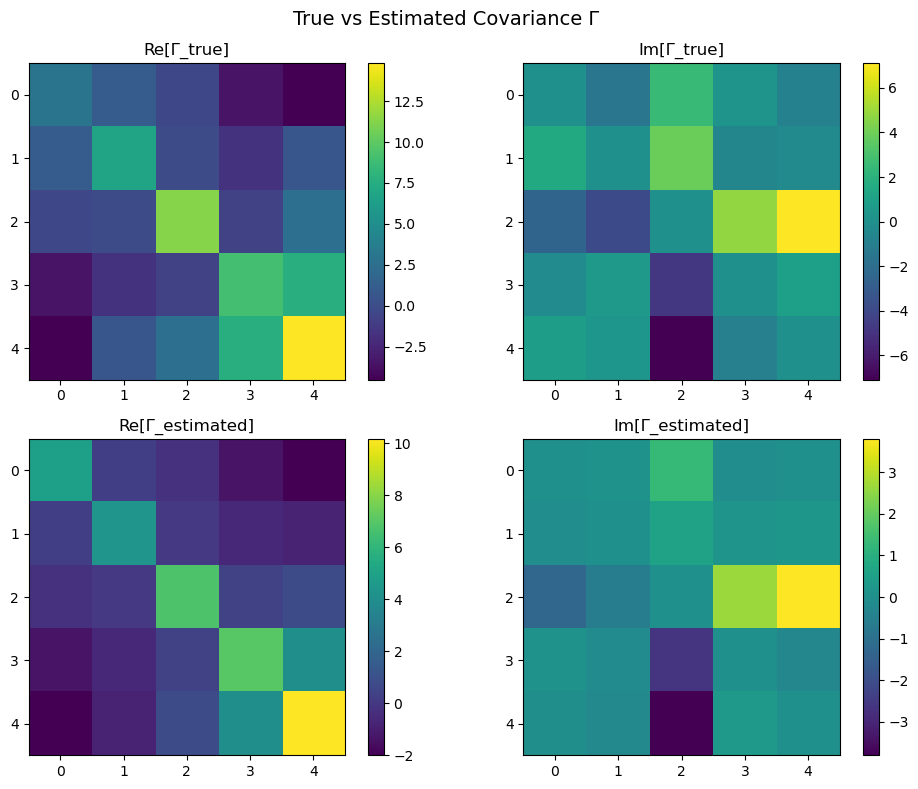

In [67]:
plot_complex_matrix_comparison(Gamma_true, Gamma_mean)

In [68]:
true_lambdas, _ = jnp.linalg.eigh(Gamma_true)
mean_lambdas, _ = jnp.linalg.eigh(Gamma_mean)

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eigenvalue_mean(posterior_log_lambda, true_lambdas):
    """
    Plot the posterior mean of the eigenvalues on a log scale.
    """
    lambdas_mean = np.exp(posterior_log_lambda).mean(axis=0)

    plt.figure(figsize=(6, 4))
    plt.plot(np.sort(true_lambdas)[::-1], "o-", color='k')
    plt.plot(np.sort(lambdas_mean)[::-1], "o-")
    # plt.yscale("log")
    plt.xlabel("Index (sorted)")
    plt.ylabel("Posterior Mean Eigenvalue")
    plt.title("Posterior Mean of Eigenvalues (log scale)")
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.show()


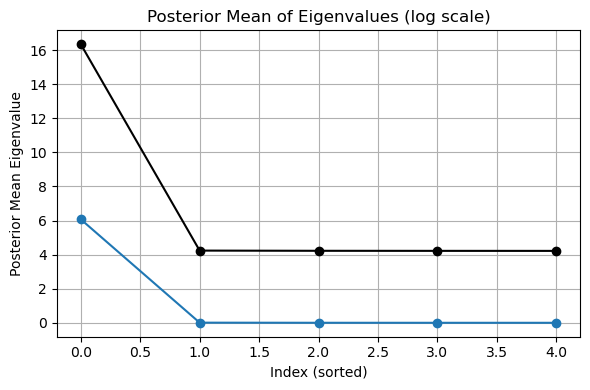

In [71]:
plot_eigenvalue_mean(posterior['log_lambda'], mean_lambdas)

In [ ]:
func(posterior[param_name])

Array([[0.2924258 , 1.2099845 , 4.4601693 ],
       [0.3135339 , 1.5144963 , 4.136565  ],
       [0.30246902, 1.6524634 , 4.21007   ],
       ...,
       [0.23286161, 1.5021538 , 4.1317396 ],
       [0.24552497, 1.2090564 , 3.7658548 ],
       [0.28857914, 1.1765733 , 3.9158733 ]], dtype=float32)